In [574]:
import numpy as np
import pandas as pd
import nltk
#nltk.download('punkt') # one time execution
import re
import spacy
nlp = spacy.load("en_core_web_lg")
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config, pipeline
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)


import plotly
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline


"""
Documentation: https://pypi.org/project/fuzzywuzzy/
"""
from fuzzywuzzy import fuzz
from fuzzywuzzy import process


from textblob import TextBlob


from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
#nltk.download('vader_lexicon')


import seaborn as sns
from IPython.display import HTML

# Functions

In [606]:
# 1. TOP 10 WORDS
def top_10_words(text_nlp):
    """
    This function returns dataframe with top 10 words with their frequency and percentage over all words
    """
    # Prerocessing by lemmatization, no punctuation and no stop words
    all_tokens = [token.lemma_ for token in text_nlp if not token.is_punct and not (token.is_stop) ]
    
    # Getting the most common 10 words by using 'Counter' class
    most_common_10 = Counter(all_tokens).most_common(10)
    
    # Top 10 words in a list
    top_10_words = [each[0] for each in most_common_10]
    
    # words frequency in a list
    top_10_counts = [each[1] for each in most_common_10]
    
    # words percentage over all the words
    top_10_percentage = [str(round(each[1]/len(all_tokens) * 100, 2))+'%' for each in most_common_10]
    
    # creating dataframe
    top_10_df = pd.DataFrame(data = {'Word': top_10_words, 'Frequency': top_10_counts, 'Percentage': top_10_percentage})
    
    # ===-- Barchart Creation Start --=== #
    
    # Barchart and saving
    top_10_df.iplot(kind = 'bar', x = 'Word', y = ['Frequency', 'Percentage'], yTitle='Frequency & Percentage Ratio', xTitle='Word', linecolor='black', title='Top 10 words Frequency and Percentage ratio over all the words in text', asImage=True)
    
    # ===-- Barchart Creation End --=== #
    
    
    # ===-- WordCloud Creation Start --=== #
    
    # Preparing the text format for wordcloud text generator, multiplying all the words by frequncy and making one string
    top_words_text = " ". join((top_10_df.Word +" ") * top_10_df.Frequency).strip()
    
    # lower max_font_size, change the maximum number of word and lighten the background:
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(top_words_text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Top 10 Words")
    plt.show()
    
    # Saving the image in the img folder:
    wordcloud.to_file("top_10_words_wordcloud.png")
    
    # ===-- WordCloud Creation End --=== #
    
    return top_10_df
#----------------------------------------------------------------------------------------------#


# 2. TOP PHRASES
def top_phrases(text_nlp):

    """
    This Function Gets nlp text and returns barchart and dataframe with top 10 phrases where count is more than 1 
    """

    # Prerocessing by removing tokens where are 'the' or 'a', not want to make phrases with them
    all_tokens = " ".join([token.text for token in text_nlp if token.text not in ['the', 'The','a']])

    # Making nlp text
    pre_text = nlp(all_tokens)

    # Getting all the phrases where the length is more than one, want to keep only lengthy phrases not single words
    all_chunks = [chunk.text for chunk in pre_text.noun_chunks if len(chunk.text.split(" ")) > 1]

    # In this variable assigning all the phrases and repeating where founded similar phrases, so we can increase their frequency after woth Counter function
    new_chunks = []

    # Flag variable, where we assign all the seen positions, so we dont repeat adding the same phrases
    seen_position = []

    # Iterating over all the phrases and checking whether phrases are repeating, so we can count them the same
    for phares in all_chunks:
        for i in range(len(all_chunks)):
            phares2 = all_chunks[i]
            if fuzz.token_sort_ratio(phares, phares2) > 80 and i not in seen_position:
                new_chunks.append(phares)
                seen_position.append(i)


    # Counting all the phrasess
    phrases_frequency = Counter(new_chunks)

    # Getting only those phrases where the count is more than 1 
    most_common_10_more_than_one = Counter({key: count for key, count in phrases_frequency.items() if count > 1}).most_common(10)


    # Top 10 words in a list
    top_10_phrases = [each[0] for each in most_common_10_more_than_one]

    # words frequency in a list
    top_10_counts = [each[1] for each in most_common_10_more_than_one]


    # creating dataframe
    top_10_df = pd.DataFrame(data = {'Phrase': top_10_phrases, 'Frequency': top_10_counts})

    # ===-- Barchart Creation Start --=== #

    # Barchart and saving
    top_10_df.iplot(kind = 'bar', x = 'Phrase', y = 'Frequency', yTitle='Frequency', xTitle='Phrase', linecolor='black', title='Top Phrases Frequency', asImage=True)

    # ===-- Barchart Creation End --=== #

    return top_10_df
#----------------------------------------------------------------------------------------------#

# 3. TOP ENTITIES
def entities(text_nlp):
    
    """
    Returns all the entities with label, description and frequency in a dataframe if found any,
    else returns string message with no found entities.
    
    """

    # Getting all the entities in a list
    entities = [entity.text for entity in list(text_nlp.ents)]

    # Return message if entities is not found else, entitiy dataframe
    if len(entities) > 0:

        # Assigning empty dataframe, to assign the rows in the loop
        entities_df = pd.DataFrame(columns = ['Entity', 'Label', 'Description','Frequency'])

        # In this variable assigning all the enitities and repeating where founded similar entiites, so we can increase their frequency after woth Counter function
        new_entities = []

        # Flag variable, where we assign all the seen positions, so we dont repeat adding the same entities
        seen_position = []

        # Iterating over all the entities and checking whether entities are repeating, so we can count them the same
        for entity in list(text_nlp.ents):
            for i in range(len(list(text_nlp.ents))):
                entity2 = list(text_nlp.ents)[i]
                if fuzz.token_sort_ratio(entity, entity2) > 80 and i not in seen_position:
                    new_entities.append(entity)
                    seen_position.append(i)


        # Counting all the entities
        entity_frequency = Counter(new_entities)

        # Assigning each row to the dataframe
        for value, count in entity_frequency.items():
            row = {'Entity': value.text, 'Label': value.label_, 'Description': spacy.explain(value.label_), 'Frequency':count}

            entities_df = entities_df.append(row, ignore_index=True)
            
        # Barchart and saving
        entities_df.iplot(kind = 'bar', x = ['Entity', 'Label'], y = 'Frequency', yTitle='Frequency', xTitle='Entity', linecolor='black', title='Entity Frequency', asImage=True)
  
        return entities_df

    else:
        return "No Entities Found!"
#----------------------------------------------------------------------------------------------#

# 4. TOP ADVERBS
def top_adverbs(text_nlp):
    """
    
    This function Returns Top Adverbs where the frequency is more than 1, if not returns message not found!
    
    """

    # Prerocessing by lemmatization, no punctuation and no stop words
    all_tokens = [token for token in text_nlp if not token.is_punct and not (token.is_stop) ]

    all_verbs = [token.lemma_ for token in all_tokens if token.pos_ == "VERB" ]


    # Counting all the phrasess
    verbs_frequency = Counter(all_verbs)

    # Getting only those phrases where the count is more than 1 
    most_common_10_more_than_one = Counter({key: count for key, count in verbs_frequency.items() if count > 1}).most_common(10)
    if len(most_common_10_more_than_one) > 0:


        # Top 10 words in a list
        top_10_verbs = [each[0] for each in most_common_10_more_than_one]

        # words frequency in a list
        top_10_counts = [each[1] for each in most_common_10_more_than_one]


        # creating dataframe
        top_verbs_df = pd.DataFrame(data = {'Verbs': top_10_verbs, 'Frequency': top_10_counts})

        # ===-- Barchart Creation Start --=== #

        # Barchart and saving
        top_verbs_df.iplot(kind = 'bar', x = 'Verbs', y = 'Frequency', yTitle='Frequency', xTitle='Verbs', linecolor='black', title='Top Verbs Frequency', asImage=True)

        # ===-- Barchart Creation End --=== #

        return top_verbs_df
    else:
        return "No adverb found with frequency more than one!"
#----------------------------------------------------------------------------------------------#

# 5. TOP ADJECTIVES    
def top_adjectives(text_nlp):
    """
    
    This function Returns Top Adjectives where the frequency is more than 1, if not returns message not found!
    
    """

    # Prerocessing by lemmatization, no punctuation and no stop words
    all_tokens = [token for token in text_nlp if not token.is_punct and not (token.is_stop) ]

    all_adjectives = [token.lemma_ for token in all_tokens if token.pos_ == "ADJ" ]


    # Counting all the phrasess
    adjectives_frequency = Counter(all_adjectives)

    # Getting only those phrases where the count is more than 1 
    most_common_10_more_than_one = Counter({key: count for key, count in adjectives_frequency.items() if count > 1}).most_common(10)
    if len(most_common_10_more_than_one) > 0:


        # Top 10 words in a list
        top_10_adjectives = [each[0] for each in most_common_10_more_than_one]

        # words frequency in a list
        top_10_counts = [each[1] for each in most_common_10_more_than_one]


        # creating dataframe
        top_adjectives_df = pd.DataFrame(data = {'Adjectives': top_10_adjectives, 'Frequency': top_10_counts})

        # ===-- Barchart Creation Start --=== #

        # Barchart and saving
        top_adjectives_df.iplot(kind = 'bar', x = 'Adjectives', y = 'Frequency', yTitle='Frequency', xTitle='Adjectives', linecolor='black', title='Top Adjectives Frequency', asImage=True)

        # ===-- Barchart Creation End --=== #

        return top_adjectives_df
    else:
        return "No Adjectives found with frequency more than one!"
#----------------------------------------------------------------------------------------------#
    
    
# 6. TOP NOUNS   
def top_nouns(text_nlp):
    """
    
    This function Returns Top Nouns where the frequency is more than 1, if not returns message not found!
    
    """

    # Prerocessing by lemmatization, no punctuation and no stop words
    all_tokens = [token for token in text_nlp if not token.is_punct and not (token.is_stop) ]

    all_nouns = [token.lemma_ for token in all_tokens if token.pos_ == "NOUN" ]


    # Counting all the phrasess
    nouns_frequency = Counter(all_nouns)

    # Getting only those phrases where the count is more than 1 
    most_common_10_more_than_one = Counter({key: count for key, count in nouns_frequency.items() if count > 1}).most_common(10)
    if len(most_common_10_more_than_one) > 0:


        # Top 10 words in a list
        top_10_nouns = [each[0] for each in most_common_10_more_than_one]

        # words frequency in a list
        top_10_counts = [each[1] for each in most_common_10_more_than_one]


        # creating dataframe
        top_nouns_df = pd.DataFrame(data = {'Nouns': top_10_nouns, 'Frequency': top_10_counts})

        # ===-- Barchart Creation Start --=== #

        # Barchart and saving
        top_nouns_df.iplot(kind = 'bar', x = 'Nouns', y = 'Frequency', yTitle='Frequency', xTitle='Nouns', linecolor='black', title='Top Nouns Frequency', asImage=True)

        # ===-- Barchart Creation End --=== #

        return top_nouns_df
    else:
        return "No Nouns found with frequency more than one!"
    

#----------------------------------------------------------------------------------------------#
    
# 7. SENTIMENT ANALYSIS      
def sentiment_anlysis(text_nlp):

    """
    Returns two dictiniories with polarity and subjectivity score for each sentence
    
    """

    sentiment_df = pd.DataFrame(columns = ['Sentence', 'Polarity', 'Subjectivity'])
    sid = SentimentIntensityAnalyzer()

    polarity_sentences = dict()
    subjectivity_sentences = dict()

    for sent in text_nlp.sents:
        testimonial = TextBlob(sent.text)
        polarity = testimonial.sentiment.polarity
        subjectivity = testimonial.sentiment.subjectivity

        polarity_sentences[sent.text] = polarity
        subjectivity_sentences[sent.text] = subjectivity

        row_value = {'Sentence': sent.text, 'Polarity': polarity, 'Subjectivity': subjectivity}
        sentiment_df = sentiment_df.append(row_value, ignore_index = True)

    polarity_sentences_sorted = {k: v for k, v in sorted(polarity_sentences.items(), key=lambda item: item[1], reverse = True)}
    subjectivity_sentences_sorted = {k: v for k, v in sorted(subjectivity_sentences.items(), key=lambda item: item[1], reverse = True)}
    
    return polarity_sentences_sorted, subjectivity_sentences_sorted

#-------------#

def display_polarity_subjectivity(polarity_sentences_sorted, subjectivity_sentences_sorted):
    
    counter = 0
    
    for key, value in polarity_sentences_sorted.items():
        if (counter >= 0 and counter < 3) or (counter >= len(polarity_sentences_sorted) - 3):
            print('Sentence:')
            print(key)
            print()
            print('Polarity:')
            print(str(round(value * 100, 2))+'%')
            print()
            print('Subjectivity:')
            print(str(round(subjectivity_sentences_sorted[key] * 100, 2))+'%')
            print()
            print("----------------------------------------------------------")
            print()
            
        counter+=1
        
        
#----------------------------------------------------------------------------------------------#

# 8. TOPIC MODELING 
def topic_modeling(text_nlp):
    
    # Importing Libraries
    import re
    import numpy as np
    import pandas as  pd
    from pprint import pprint# Gensim
    import gensim
    import gensim.corpora as corpora
    from gensim.utils import simple_preprocess
    from gensim.models import CoherenceModel# spaCy for preprocessing
    import spacy# Plotting tools
    from spacy.lang.en.stop_words import STOP_WORDS
    import pyLDAvis
    import pyLDAvis.gensim
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    
    #------------#
    # Tokenize words and cleanup the text
    # Using gensims simple_preprocess(), set deacc=True to remove punctuations.
    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))   #deacc=True removes punctuations

    data_words = list(sent_to_words(text_nlp.sents))
    
    
    #------------#
    # Creating Bigram and Trigram models
    ## Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=1, threshold=40) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=40)

    ## Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    
    #------------#
    # Removing Stopwords, make bigrams and lemmatize
    # Defining function for stopwords, bigrams, trigrams and lemmatization
    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in STOP_WORDS] for doc in texts]

    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]

    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out
    
    
    #------------#
    # Calling the functions in order
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)


    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    
    #------------#
    # Createing Dictionary and Corpus needed for Topic Modeling
    # Create Dictionary 
    id2word = corpora.Dictionary(data_lemmatized)  
    # Create Corpus 
    texts = data_lemmatized  
    # Term Document Frequency 
    corpus = [id2word.doc2bow(text) for text in texts]  
    
    
    #------------#
    # Building topic model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, # Given best coherence score
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=20, # Given best coherence score, after test 
                                           alpha='auto',
      
                                                per_word_topics=True)
    
    #------------#
    ## Getting only the keywords, without probability for visualization
    only_keywords = []

    for each in lda_model.show_topics(formatted = False):
        each_key_words = ", ".join([word[0] for word in each[1]])
        only_keywords.append(each_key_words)
        
    #------------#
    # Retruning
    return lda_model, only_keywords
    
    
    #------------#
    ## Evaluate topic models
    ## Compute Perplexity
    #print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
    ## a measure of how good the model is. lower the better.


    ## Compute Coherence Score
    #coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    #coherence_lda = coherence_model_lda.get_coherence()
    #print('\nCoherence Score: ', coherence_lda)
    
    
    #------------#
    ## Visualize the topics
    #pyLDAvis.enable_notebook()
    #vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    #vis
    
    
#-------------#

def display_topics_word_cloud(lda_model, only_keywords):

    #Word Clouds of Top N Keywords in Each Topic
    #Though you’ve already seen what are the topic keywords in each topic, a word cloud with the size of the words proportional to the weight is a pleasant sight. The coloring of the topics I’ve taken here is followed in the subsequent plots as well.

    # 1. Wordcloud of Top N words in each topic
    from matplotlib import pyplot as plt
    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.colors as mcolors

    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

    cloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = lda_model.show_topics(formatted=False)

    fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)


    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()
    
    fig.savefig('topics_word_cloud.png')
    
    
    for i in range(len(only_keywords)):
        print(f"Topic: {i+1}")
        print(f"Keywords: {only_keywords[i]}")
        print()
        

#----------------------------------------------------------------------------------------------#

# 9. ABSTRACTIVE TEXT SUMMARIZATION T5 
def text_summarization_T5(text):
    
    preprocess_text = text.strip().replace("\n","")
    

    summarizer = pipeline("summarization")
    summrized_text = summarizer(preprocess_text, 
                                num_beams=4,
                                #max_length=500, 
                                min_length=30, 
                                do_sample=False)[0]['summary_text']
    return summrized_text

    # Different way to do, need to check the diferences between those two types
    """ 
    # Importing T5 google's pre-trained text generation model
    model = T5ForConditionalGeneration.from_pretrained('t5-large')
    tokenizer = T5Tokenizer.from_pretrained('t5-large')
    device = torch.device('cpu')


    t5_prepared_Text = "summarize: " + preprocess_text
    tokenized_text = tokenizer.encode(t5_prepared_Text, return_tensors="pt", max_length=512, truncation=True).to(device)

    # summmarize 
    summary_ids = model.generate(tokenized_text,
                                        num_beams=4,
                                        min_length=30,
                                        max_length=500,
                                        early_stopping=True)

    output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    print ("\n\nSummarized text: \n",output)
    
    """

    
#----------------------------------------------------------------------------------------------#

# 10. EXTRACTIVE TEXT SUMMARIZATION TEXTRANK   
def extractive_summarization(sentences):

    from nltk.corpus import stopwords
    from nltk.cluster.util import cosine_distance
    import numpy as np
    import networkx as nx


    def sentence_similarity(sent1, sent2, stopwords=None):
        if stopwords is None:
            stopwords = []

        sent1 = [w.lower() for w in sent1]
        sent2 = [w.lower() for w in sent2]

        all_words = list(set(sent1 + sent2))

        vector1 = [0] * len(all_words)
        vector2 = [0] * len(all_words)

        # build the vector for the first sentence
        for w in sent1:
            if w in stopwords:
                continue
            vector1[all_words.index(w)] += 1

        # build the vector for the second sentence
        for w in sent2:
            if w in stopwords:
                continue
            vector2[all_words.index(w)] += 1

        return 1 - cosine_distance(vector1, vector2)

    def build_similarity_matrix(sentences, stop_words):
        # Create an empty similarity matrix
        similarity_matrix = np.zeros((len(sentences), len(sentences)))

        for idx1 in range(len(sentences)):
            for idx2 in range(len(sentences)):
                if idx1 == idx2: #ignore if both are same sentences
                    continue 
                similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)

        return similarity_matrix


    def generate_summary(sentences, top_n=5):
        stop_words = stopwords.words('english')
        summarize_text = []

        # Step 2 - Generate Similary Martix across sentences
        sentence_similarity_martix = build_similarity_matrix(sentences, stop_words)

        # Step 3 - Rank sentences in similarity martix
        sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
        scores = nx.pagerank(sentence_similarity_graph)

        # Step 4 - Sort the rank and pick top sentences
        ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True) 
        #print("Indexes of top ranked_sentence order are ", ranked_sentence)    

        for i in range(top_n):
            summarize_text.append(ranked_sentence[i][1])

        # Step 5 - Offcourse, output the summarize texr
        #print("Summarize Text: \n", ". ".join(summarize_text))
        return " ".join(summarize_text)
    

    # let's begin
    return generate_summary(sentences, 2)

# MAIN

### Recommendation Text

In [28]:
text = """
To reduce the risk of improper payments (either over- or under-reimbursing subrecipients due to error or fraud), 
the Commissioner should ensure the Interim Director of Community Services establishes a preventative control to 
ensure the accuracy of subrecipients’ meal reimbursement claims before the department remits payments. 
If the department cannot establish a preventative control, in order to recoup the federal funds and address any 
fraud risks timely, the department should increase its focus on EPR monitoring to ensure it is robust and extensive
enough to detect when a subrecipient was paid in error. 
To increase the likelihood of detecting overpayments, EPR monitors should expand their monitoring activities when 
they find claim errors during their limited reviews. 
These expanded activities should include analytical tools to identify claim errors or anomalies. 
When expanded monitoring activities identify pervasive compliance and control deficiencies, 
EPR monitors and program management must take appropriate follow-up action to ensure subrecipients implement 
correct controls.
Underpayments to subrecipients do not give rise to federal questioned costs; 
however the department should ensure that subrecipients are not underpaid as this can negatively impact 
the financial condition of the subrecipients the department relies on to provide meals to eligible individuals.
The Commissioner, the Interim Inspector General, and the Interim Director of Community Services should ensure 
that the department recovers $13,688 from the subrecipients for the issues noted in the finding.
The Commissioner should assess all significant risks, including the risks noted in this finding, 
in the department’s annual risk assessment. 
The risk assessment and the mitigating controls should be adequately documented and approved by the Commissioner. 
The Commissioner should implement effective controls to ensure compliance with applicable requirements; 
assign employees to be responsible for ongoing monitoring of the risks and any mitigating controls; 
and take immediate action if deficiencies occur.
"""

preprocess_text = text.strip().replace("\n","")
text_nlp = nlp(preprocess_text)

## 1. Top 10 words

Displaying most frequent top 10 words and their percentage over all the words.

Note! Excluding all the stop words(a, in, the, etc) and all the punctuations

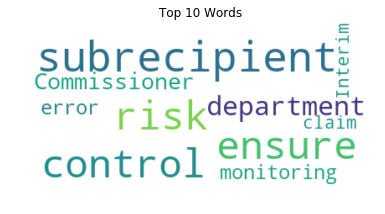

,Word,Frequency,Percentage
0,subrecipient,8,4.65%
1,risk,7,4.07%
2,ensure,7,4.07%
3,control,7,4.07%
4,department,7,4.07%
5,Commissioner,5,2.91%
6,error,4,2.33%
7,monitoring,4,2.33%
8,Interim,3,1.74%
9,claim,3,1.74%


In [142]:
top_words = top_10_words(text_nlp)
top_words

## 2. Top Phrases

Displaying Top Phrases found in the text and their frequency

In [616]:
top_phrases = top_phrases(text_nlp)
top_phrases

,Phrase,Frequency
0,EPR monitoring,3
1,Interim Director,2
2,Community Services,2
3,preventative control,2
4,claim errors,2


## 3. Entities

Displaying Entities found in the text with their label, description and frequency

In [280]:
entities_df = entities(text_nlp)
entities_df

,Entity,Label,Description,Frequency
0,the Interim Director of Community Services,ORG,"Companies, agencies, institutions, etc.",2
1,EPR,ORG,"Companies, agencies, institutions, etc.",2
2,the Interim Inspector General,ORG,"Companies, agencies, institutions, etc.",1
3,"13,688",MONEY,"Monetary values, including unit",1
4,annual,DATE,Absolute or relative dates or periods,1


## 4. Top Adverbs

Displaying Top Adverbs found in the text with their frequency

In [622]:
top_adverbs = top_adverbs(text_nlp)
top_adverbs

,Verbs,Frequency
0,ensure,7
1,expand,3
2,establish,2
3,increase,2
4,detect,2
5,include,2
6,identify,2
7,implement,2
8,note,2
9,mitigate,2


## 4. Top Adjectives

Displaying Top Adjectives found in the text with their frequency

In [626]:
top_adjectives = top_adjectives(text_nlp)
top_adjectives

,Adjectives,Frequency
0,preventative,2
1,federal,2


## 5. Top Nouns

Displaying Top Nouns found in the text with their frequency

In [610]:
top_nouns =  top_nouns(text_nlp)
top_nouns

,Nouns,Frequency
0,subrecipient,8
1,control,7
2,department,7
3,risk,6
4,error,4
5,monitoring,4
6,claim,3
7,activity,3
8,payment,2
9,fraud,2


## 6. Sentiment Analysis

Performing Sentiment Analysis


Sentiment analysis or sentiment classification is supposed to tell ,whether given phrase or sentence is positive, negative or neutral.

Polarity is a float value within the range [-1.0 to 1.0]:
    * 0 indicates neutral
    * +1 indicates a very positive sentiment 
    * -1 represents a very negative sentiment
    


The subjective sentence expresses some personal feelings, views, beliefs, opinions, allegations, desires, beliefs, suspicions, and speculations.
Objective sentences are factual.

Subjectivity is a float value within the range [0.0 to 1.0] 
    * 0.0 is very objective 
    * 1.0 is very subjective. 
    


#### Displaying Polarity three most positive(+) and three most negative(-) sentences

In [393]:
polarity_sentences_sorted, subjectivity_sentences_sorted = sentiment_anlysis(text_nlp)
display_polarity_subjectivity(polarity_sentences_sorted, subjectivity_sentences_sorted)

Sentence:
The Commissioner should assess all significant risks, including the risks noted in this finding, in the department’s annual risk assessment.

Polarity:
37.5%

Subjectivity:
87.5%

----------------------------------------------------------

Sentence:
The risk assessment and the mitigating controls should be adequately documented and approved by the Commissioner.

Polarity:
33.33%

Subjectivity:
33.33%

----------------------------------------------------------

Sentence:
When expanded monitoring activities identify pervasive compliance and control deficiencies, EPR monitors and program management must take appropriate follow-up action to ensure subrecipients implement correct controls.

Polarity:
30.0%

Subjectivity:
30.0%

----------------------------------------------------------

Sentence:
To increase the likelihood of detecting overpayments, EPR monitors should expand their monitoring activities when they find claim errors during their limited reviews.

Polarity:
-7.14%

S

## 7. Topic Modeling

Displaying optimal number of topics found on the given text with their keywords

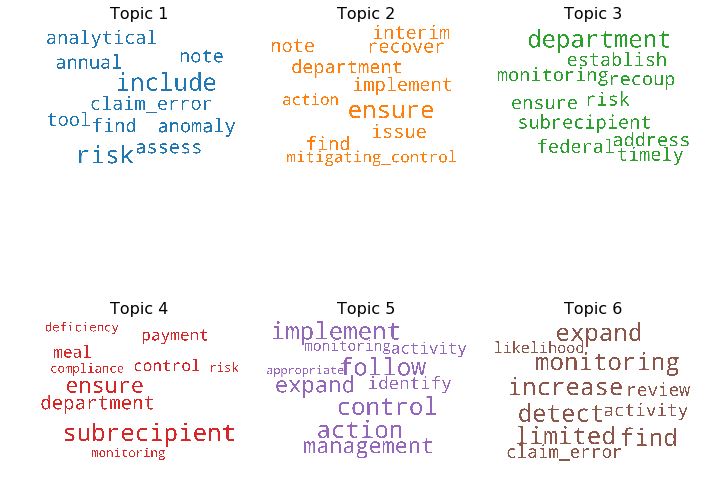

Topic: 1
Keywords: include, risk, note, find, annual, assess, analytical, claim_error, anomaly, tool

Topic: 2
Keywords: ensure, department, note, recover, issue, find, interim, implement, mitigating_control, action

Topic: 3
Keywords: department, federal, ensure, subrecipient, establish, recoup, risk, monitoring, address, timely

Topic: 4
Keywords: subrecipient, ensure, department, payment, meal, control, risk, compliance, deficiency, monitoring

Topic: 5
Keywords: control, implement, follow, action, expand, management, identify, activity, monitoring, appropriate

Topic: 6
Keywords: detect, increase, monitoring, find, expand, limited, claim_error, activity, review, likelihood



In [565]:
lda_model, only_keywords = topic_modeling(text_nlp)
display_topics_word_cloud(lda_model, only_keywords)

## 8. Text Summarization

### 8.1. Abstractive Text Summarization

Abstractive methods select words based on semantic understanding, even those words did not appear in the source documents.

It aims at producing important material in a new way. 

They interpret and examine the text using advanced natural language techniques in order to generate a new shorter text that conveys the most critical information from the original text.

It can be correlated to the way human reads a text article or blog post and then summarizes in their own word.

In [585]:
text_summarization_T5(text).strip()

'To reduce the risk of improper payments, the Commissioner should ensure the Interim Director of Community Services establishes a preventative control to ensure accuracy of subrecipients’ meal reimbursement claims before the department remits payments . EPR monitors should expand their monitoring activities when they find claim errors .'

### 8.2. Extractive Text Summarization

Extractive methods attempt to summarize articles by selecting a subset of words that retain the most important points.

This approach weights the important part of sentences and uses the same to form the summary. 

Different algorithm and techniques are used to define weights for the sentences and further rank them based on importance and similarity among each other.

Input document → sentences similarity → weight sentences → select sentences with higher rank.

In [605]:
sentences = [sent.text for sent in text_nlp.sents]
extractive_summarization(sentences)

'Underpayments to subrecipients do not give rise to federal questioned costs; however the department should ensure that subrecipients are not underpaid as this can negatively impact the financial condition of the subrecipients the department relies on to provide meals to eligible individuals. If the department cannot establish a preventative control, in order to recoup the federal funds and address any fraud risks timely, the department should increase its focus on EPR monitoring to ensure it is robust and extensiveenough to detect when a subrecipient was paid in error.'